In [1]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt
import warnings
from xgcm import Grid
import importlib
import preprocessing
import os
import xrft
import gcm_filters
import random

warnings.filterwarnings("ignore")

importlib.reload(preprocessing)
from preprocessing import preprocess_data

from gcm_filtering import filter_inputs_dataset
from gcm_filtering import filter_inputs

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset


# Background

$\text{Total heat flux = latent heat flux + sensible heat flux} = Q_L + Q_H\\$
$Q_H = \rho\, C_H\, C_P \,[\theta_Z - T_s]\, U_B \\$
$Q_L = -L_v\, \rho\, C_E\, [q_s - q_z]\, U_B\\$


$U_B = \text{bulk scalar wind speed at reference height} \\ $
$\theta_z = \text{potential temperature at reference height} \\ $
$q_z = \text{specific humidity of air at the reference height} \\ $
$T_s = \text{temperature at air-sea interface} \\ $
$q_s = \text{specific humidity at air-sea interface} \\ $
$C_D = \text{drag coefficient} \\ $
$C_E = \text{evaporation coefficient} \\ $
$C_H = \text{sensible heat coefficient} \\ $
$L_v = \text{latent heat of vaporization} $

- We assume the NN can find the constant values of the four coefficients
- We assume $T_s \approx \theta_z$, since our reference height is 2m and $p_s \approx p_z$
- We know $q_{z} = rh_{z} * q_s$. Thus, we use $q_z$ and $rh_z$ for training inputs.
- We get $U_B, T_s, q_z$ from our climate model data.
- $U_B$ can be found from $u_z, v_z$

# Prep training data

In [2]:
ds_merged = preprocess_data()
ds_merged

Load Data
Interpolating ocean velocities
Modify units
Load Data
Align in time
Interpolating ocean velocities
Regrid Atmospheric Data
Modify units
Mask nans
Calculate relative wind


<xarray.Dataset> Size: 3TB
Dimensions:       (time: 7305, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time          (time) object 58kB 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean      (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.85 79.95
  * yt_ocean      (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.94 89.98
    area_t        (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t      (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t      (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ht            (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    kmt           (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    wet           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
Data variables:
    slp           (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    q_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    rh_ref        (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [3]:
ds_in = ds_merged.drop(['area_t', 'dxt', 'dyt', 'geolat_t', 'geolon_t', 'ht', 'kmt', 'wet'])
ds_temp = ds_in.isel(time=slice(0,365))
ds_AeroBulk_inputs = ds_temp.sel(yt_ocean=slice(-30, -15), xt_ocean=slice(-25, -10)) # South Atlantic
ds_AeroBulk_inputs

<xarray.Dataset> Size: 428MB
Dimensions:       (time: 365, yt_ocean: 163, xt_ocean: 150)
Coordinates:
  * time          (time) object 3kB 0181-01-01 12:00:00 ... 0181-12-31 12:00:00
  * xt_ocean      (xt_ocean) float64 1kB -24.95 -24.85 -24.75 ... -10.15 -10.05
  * yt_ocean      (yt_ocean) float64 1kB -29.98 -29.89 -29.81 ... -15.17 -15.07
Data variables:
    slp           (time, yt_ocean, xt_ocean) float32 36MB dask.array<chunksize=(3, 163, 150), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 36MB dask.array<chunksize=(3, 163, 150), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 36MB dask.array<chunksize=(3, 163, 150), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 36MB dask.array<chunksize=(3, 163, 150), meta=np.ndarray>
    q_ref         (time, yt_ocean, xt_ocean) float32 36MB dask.array<chunksize=(3, 163, 150), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float32 36MB dask.array<chunksize=(3, 163, 150), meta=np.ndarray>
    rh_ref        (time, yt_ocean, xt_ocean) float32 36MB dask.array<chunksize=(3, 163, 150), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 36MB dask.array<chunksize=(3, 163, 150), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 36MB dask.array<chunksize=(3, 163, 150), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 36MB dask.array<chunksize=(3, 163, 150), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 36MB dask.array<chunksize=(3, 163, 150), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 36MB dask.array<chunksize=(3, 163, 150), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [4]:
heatFlux_HR = xr.open_dataset(
    "gs://leap-persistent/panalluri/HF_highRes.zarr", engine="zarr", chunks={}
)
heatFlux_HR

<xarray.Dataset> Size: 14GB
Dimensions:                        (time: 365, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time                           (time) object 3kB 0181-01-01 12:00:00 ... ...
  * xt_ocean                       (xt_ocean) float64 29kB -279.9 ... 79.95
  * yt_ocean                       (yt_ocean) float64 22kB -81.11 ... 89.98
Data variables:
    __xarray_dataarray_variable__  (time, yt_ocean, xt_ocean) float32 14GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>

In [5]:
heatFlux_HR_temp = heatFlux_HR.isel(time=slice(0,365))
heatFlux_HR_temp_AeroBulk = heatFlux_HR_temp.sel(yt_ocean=slice(-30, -15), xt_ocean=slice(-25, -10)) # South Atlantic
heatFlux_HR_temp_AeroBulk

<xarray.Dataset> Size: 36MB
Dimensions:                        (time: 365, yt_ocean: 163, xt_ocean: 150)
Coordinates:
  * time                           (time) object 3kB 0181-01-01 12:00:00 ... ...
  * xt_ocean                       (xt_ocean) float64 1kB -24.95 ... -10.05
  * yt_ocean                       (yt_ocean) float64 1kB -29.98 ... -15.07
Data variables:
    __xarray_dataarray_variable__  (time, yt_ocean, xt_ocean) float32 36MB dask.array<chunksize=(3, 163, 150), meta=np.ndarray>

In [6]:
# Set number of time samples
time_training = ds_AeroBulk_inputs['time'][::10][:-9]

# Extract needed data
urel_data_train = ds_AeroBulk_inputs.u_relative.sel(time=time_training).values
vrel_data_train = ds_AeroBulk_inputs.v_relative.sel(time=time_training).values
sst_data_train = ds_AeroBulk_inputs.surface_temp.sel(time=time_training).values
tref_data_train = ds_AeroBulk_inputs.t_ref.sel(time=time_training).values
qref_data_train = ds_AeroBulk_inputs.q_ref.sel(time=time_training).values
relHum_data_train = ds_AeroBulk_inputs.rh_ref.sel(time=time_training).values
heatFlux_HR_data_train = heatFlux_HR_temp_AeroBulk.__xarray_dataarray_variable__.sel(time=time_training).values

# Stack these arrays into a 4D tensor
# Shape will be (time, yt_ocean, xt_ocean, num_variables)
training_NN_inputs = torch.tensor(np.stack([urel_data_train, vrel_data_train, sst_data_train, tref_data_train, qref_data_train, relHum_data_train, heatFlux_HR_data_train], axis=3))

# Now data_array is a 4D tensor
training_NN_inputs

tensor([[[[-1.1438e+00, -6.7958e+00,  2.9378e+02,  ...,  1.3908e-02,
            9.3829e+01, -2.3919e+01],
          [-1.2333e+00, -6.7517e+00,  2.9375e+02,  ...,  1.3894e-02,
            9.3746e+01, -2.3249e+01],
          [-1.3254e+00, -6.7120e+00,  2.9376e+02,  ...,  1.3880e-02,
            9.3664e+01, -2.3719e+01],
          ...,
          [-6.4327e+00,  1.3818e+00,  2.9423e+02,  ...,  1.0697e-02,
            8.0195e+01, -1.4523e+02],
          [-6.4592e+00,  1.4741e+00,  2.9423e+02,  ...,  1.0706e-02,
            8.0266e+01, -1.4604e+02],
          [-6.4968e+00,  1.5383e+00,  2.9426e+02,  ...,  1.0715e-02,
            8.0337e+01, -1.4803e+02]],

         [[-1.0826e+00, -6.7662e+00,  2.9384e+02,  ...,  1.3966e-02,
            9.3880e+01, -2.3883e+01],
          [-1.1725e+00, -6.7148e+00,  2.9382e+02,  ...,  1.3955e-02,
            9.3793e+01, -2.3226e+01],
          [-1.2645e+00, -6.6675e+00,  2.9383e+02,  ...,  1.3944e-02,
            9.3705e+01, -2.3627e+01],
          ...,
     

In [7]:
# Set number of time samples
time_testing = ds_AeroBulk_inputs['time'][::10][-9:]

# Create empty arrays (with NaNs) for preallocation
urel_data_test = ds_AeroBulk_inputs.u_relative.sel(time=time_testing).values
vrel_data_test = ds_AeroBulk_inputs.v_relative.sel(time=time_testing).values
sst_data_test = ds_AeroBulk_inputs.surface_temp.sel(time=time_testing).values
tref_data_test = ds_AeroBulk_inputs.t_ref.sel(time=time_testing).values
qref_data_test = ds_AeroBulk_inputs.q_ref.sel(time=time_testing).values
relHum_data_test = ds_AeroBulk_inputs.rh_ref.sel(time=time_testing).values
heatFlux_HR_data_test = heatFlux_HR_temp_AeroBulk.__xarray_dataarray_variable__.sel(time=time_testing).values

# Stack these arrays into a 4D tensor
# Shape will be (time, yt_ocean, xt_ocean, num_variables)
testing_NN_inputs = torch.tensor(np.stack([urel_data_test, vrel_data_test, sst_data_test, tref_data_test, qref_data_test, relHum_data_test, heatFlux_HR_data_test], axis=3))

# Now data_array is a 4D tensor
testing_NN_inputs

tensor([[[[ 3.5824e+00, -8.1308e+00,  2.8982e+02,  ...,  1.0604e-02,
            9.0050e+01, -2.3689e+01],
          [ 3.5929e+00, -8.0984e+00,  2.9007e+02,  ...,  1.0585e-02,
            8.9900e+01, -3.4490e+01],
          [ 3.5922e+00, -8.1017e+00,  2.9027e+02,  ...,  1.0566e-02,
            8.9751e+01, -4.3631e+01],
          ...,
          [ 2.2899e+00, -3.7222e+00,  2.8881e+02,  ...,  7.5552e-03,
            7.5933e+01, -6.7114e+01],
          [ 2.3059e+00, -3.6809e+00,  2.8876e+02,  ...,  7.5153e-03,
            7.5673e+01, -6.6686e+01],
          [ 2.3202e+00, -3.6380e+00,  2.8877e+02,  ...,  7.4756e-03,
            7.5413e+01, -6.7476e+01]],

         [[ 3.4837e+00, -8.1205e+00,  2.9005e+02,  ...,  1.0598e-02,
            8.9652e+01, -3.1980e+01],
          [ 3.5055e+00, -8.0880e+00,  2.9023e+02,  ...,  1.0578e-02,
            8.9489e+01, -4.0166e+01],
          [ 3.5227e+00, -8.0896e+00,  2.9038e+02,  ...,  1.0558e-02,
            8.9327e+01, -4.7264e+01],
          ...,
     

# Set up NN architecture

In [8]:
import torch
import torch.nn as nn

class SimpleANN(nn.Module):
    def __init__(self, input_size, hidden_units, output_size):
        super(SimpleANN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_units)  # First fully connected layer
        self.fc2 = nn.Linear(hidden_units, hidden_units)  # Hidden layer
        self.fc3 = nn.Linear(hidden_units, output_size)  # Output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Apply ReLU activation
        x = torch.relu(self.fc2(x))  # Apply ReLU activation
        x = self.fc3(x)  # Final layer (no activation if used for regression)
        return x

# Example setup
input_size = 6  # Number of input features
hidden_units = 64  # Number of neurons in the hidden layers
output_size = 1  # Single target output

model = SimpleANN(input_size, hidden_units, output_size)
print(model)

SimpleANN(
  (fc1): Linear(in_features=6, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)


In [9]:
from torch.utils.data import Dataset

class TensorDataset(Dataset):
    def __init__(self, tensor_data):
        self.tensor_data = tensor_data  # The 3D or 4D tensor dataset
        self.time_steps = tensor_data.shape[0]  # Total number of time steps

    def __len__(self):
        return self.time_steps  # Total number of samples (time steps)

    def __getitem__(self, idx):
        # Access the data at the specified index (time step)
        data = self.tensor_data[idx]  # Get data for the specified time step

        # Assuming the shape is (x, y, vars), extract variables as inputs and target
        # Flatten the spatial dimensions if they exist
        inputs = data.reshape(-1)[:6]  # Flatten inputs to a 1D vector (6 input features)
        
        # Extract the target, assuming it's the next variable (var 7)
        target = data.reshape(-1)[6]  # Replace 6 with the appropriate index for your target variable

        return inputs, target  # Return input (6 features) and target


# Training NN

In [10]:
train_dataset = TensorDataset(training_NN_inputs)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

In [11]:
criterion = nn.MSELoss()  # Use appropriate loss for your task
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
num_epochs = 500  # Number of epochs to train
loss_values = []

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for inputs, targets in train_loader:
        # inputs shape: [batch_size, 6]
        # targets shape: [batch_size]

        # Convert inputs and targets to float32 (if necessary)
        inputs = inputs.float()
        targets = targets.float()

        # Zero/reset the parameter gradients before the next iteration
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)  # Shape: [batch_size, 1]

        # Compute loss
        loss = criterion(outputs.squeeze(), targets)  # Squeeze to match target shape if necessary

        # Backward pass and optimization step
        loss.backward()
        optimizer.step()

        # Accumulate running loss
        running_loss += loss.item()

    # Calculate average loss for the epoch
    average_loss = running_loss / len(train_loader)

    # Store average loss in the list
    loss_values.append(average_loss)

    # Print epoch statistics
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}")

print("Training complete!")


Epoch [1/500], Loss: 20146.6230
Epoch [2/500], Loss: 19008.9082
Epoch [3/500], Loss: 17935.4531
Epoch [4/500], Loss: 16937.5352
Epoch [5/500], Loss: 15994.2422
Epoch [6/500], Loss: 15098.8506
Epoch [7/500], Loss: 14256.6846
Epoch [8/500], Loss: 13475.3447
Epoch [9/500], Loss: 12752.4717
Epoch [10/500], Loss: 12079.5312
Epoch [11/500], Loss: 11441.2354
Epoch [12/500], Loss: 10840.3281
Epoch [13/500], Loss: 10265.7412
Epoch [14/500], Loss: 9716.9307
Epoch [15/500], Loss: 9198.4854
Epoch [16/500], Loss: 8730.7529
Epoch [17/500], Loss: 8318.4521
Epoch [18/500], Loss: 7940.9023
Epoch [19/500], Loss: 7594.4263
Epoch [20/500], Loss: 7270.1138
Epoch [21/500], Loss: 6969.1528
Epoch [22/500], Loss: 6688.4272
Epoch [23/500], Loss: 6443.9229
Epoch [24/500], Loss: 6230.7446
Epoch [25/500], Loss: 6047.5181
Epoch [26/500], Loss: 5896.0464
Epoch [27/500], Loss: 5778.5537
Epoch [28/500], Loss: 5692.3491
Epoch [29/500], Loss: 5634.8374
Epoch [30/500], Loss: 5605.3564
Epoch [31/500], Loss: 5598.8755
Epoc

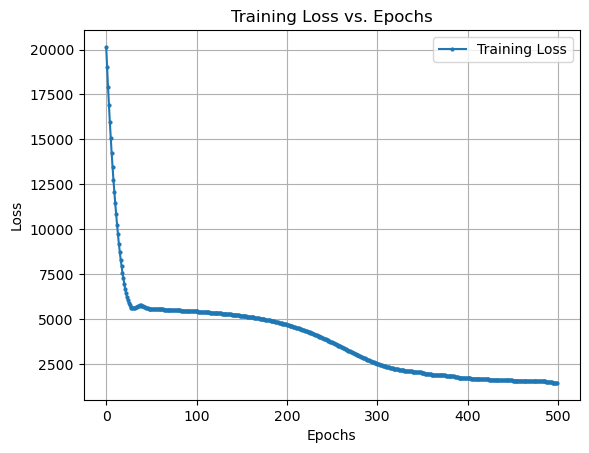

In [13]:
epochs_plot = list(range(0,num_epochs))

# Plot training losses against epochs
plt.plot(epochs_plot, loss_values, marker='o', markersize=2, label='Training Loss')

# Add labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epochs')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

# Testing dataset

In [14]:
# Flatten the input tensor to shape [num_samples, 7]
num_samples = testing_NN_inputs.shape[0] * testing_NN_inputs.shape[1] * testing_NN_inputs.shape[2]
testing_NN_inputs_flat = testing_NN_inputs.view(num_samples, 7)

# Create the test dataset and loader
test_dataset = TensorDataset(testing_NN_inputs_flat)  # Flattened tensor
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # Set shuffle=False for testing

In [15]:
def evaluate_model(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for inputs, targets in test_loader:
            # Ensure inputs and targets are float tensors
            inputs = inputs.float()  # Shape: [batch_size, 7]
            targets = targets.float()  # Shape: [batch_size]

            # Forward pass
            outputs = model(inputs)  # Shape: [batch_size, 1]

            # Calculate loss
            loss = criterion(outputs.squeeze(), targets)  # Match output and target shapes

            # Accumulate loss
            total_loss += loss.item()

            # Store predictions and targets (ensure they are 1-dimensional)
            all_predictions.append(outputs.squeeze(dim=-1))  # Ensure outputs are 1D
            all_targets.append(targets)  # Already 1D for ANN

    # Calculate average loss
    average_loss = total_loss / len(test_loader)

    # Concatenate lists into tensors
    all_predictions = torch.cat(all_predictions, dim=0)  # Shape: [num_test_samples]
    all_targets = torch.cat(all_targets, dim=0)  # Shape: [num_test_samples]

    return average_loss, all_predictions, all_targets


In [16]:
# Define your criterion (loss function)
criterion = nn.MSELoss()  # or whatever loss function you're using

# Evaluate the model on the test dataset
test_loss, predictions, targets = evaluate_model(model, test_loader, criterion)

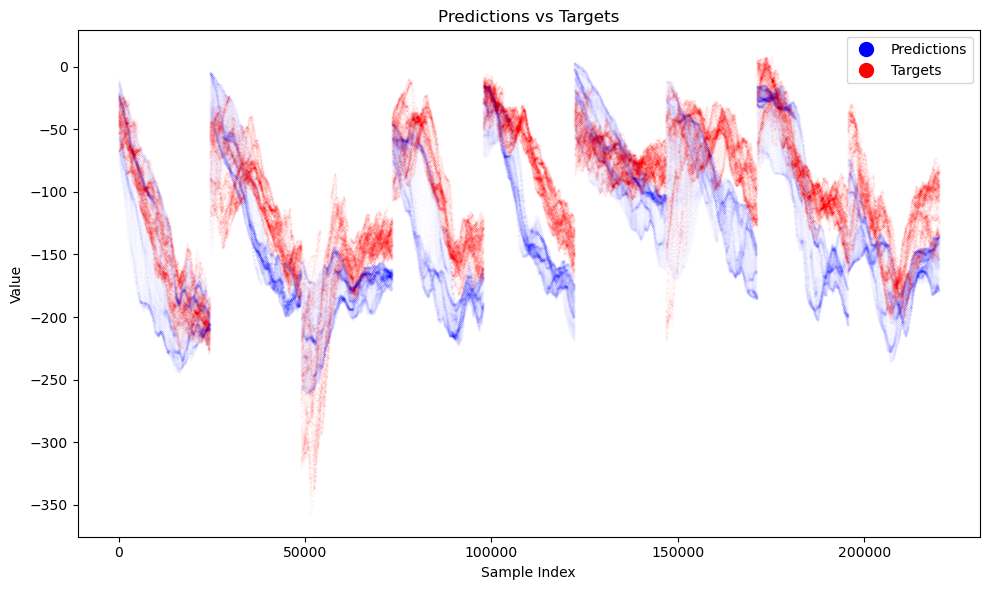

In [23]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plot_predictions_vs_targets(predictions, targets, num_samples=9, marker_size=20, legend_marker_size=10):
    # Ensure we're only plotting a limited number of samples
    num_samples = min(num_samples, predictions.shape[0])

    # Create a figure with a single subplot
    plt.figure(figsize=(10, 6))

    # Scatter plot predictions and targets with the specified marker sizes
    plt.scatter(range(num_samples), predictions[:num_samples].numpy(), label='Predictions', color='blue', marker='o', s=marker_size)
    plt.scatter(range(num_samples), targets[:num_samples].numpy(), label='Targets', color='red', marker='x', s=marker_size)

    # Create custom legend markers with no lines (only points)
    legend_handles = [
        Line2D([0], [0], marker='o', color='blue', markerfacecolor='blue', markersize=legend_marker_size, label='Predictions', linestyle=''),
        Line2D([0], [0], marker='o', color='red', markerfacecolor='red', markersize=legend_marker_size, label='Targets', linestyle='')
    ]

    # Add labels, title, and legend with custom markers
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.title('Predictions vs Targets')

    # Add the legend with custom handles (markers only)
    plt.legend(handles=legend_handles)

    # Show the plot
    plt.tight_layout()
    plt.show()

# Assuming predictions and targets are your outputs from the evaluation function
plot_predictions_vs_targets(predictions, targets, num_samples=num_samples, marker_size=0.0001, legend_marker_size=10)
